In [ ]:
import numpy as np
import random
import torch

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

# Dataset

In [ ]:
import torch
from scipy.linalg import hadamard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Cuda available: ", torch.cuda.is_available(), '\n')

# Let's create Hadamard matrix, where each row is 32x32 hadamard pattern with {-1,1} elements
px = 32
H = torch.from_numpy(hadamard(px**2)).to(device)
# In real (physical) single pixel mesurements we use matrixes
Hplus = (H + 1) / 2
Hminus = (1 - H) / 2

Cuda available:  True 



Here are the functions, which create mesurements vectror for all patterns in Hadamard basis

In [ ]:
def measurement(img):
    Mplus = torch.matmul(Hplus, img.flatten().float()).to(device)
    Mminus = torch.matmul(Hminus, img.flatten().float()).to(device)
    M = (Mplus - Mminus)

    return M

In [ ]:
def batch_measurements(imgs):
    vect = torch.zeros(len(imgs), len(imgs[0]) ** 2)

    for i in range(len(imgs)):
        img = imgs[i].to(device)
        vect[i] = measurement(img)

    return vect

Out dataset with single pixel mesuarements and their class labels

In [ ]:
from torchvision import transforms
from torch.utils.data.dataset import Dataset

class MesurementDataset(Dataset):
    def __init__(self, mnist):
        super().__init__()
        self.labels = mnist.targets
        images = mnist.data
        transform = transforms.Compose([transforms.ConvertImageDtype(torch.float32),
                                        transforms.Resize(32)])

        self.target_images = transform(images)

        self.measurements = batch_measurements(self.target_images).cpu()

    def __getitem__(self, indx):
        return self.measurements[indx], self.target_images[indx]

    def __len__(self):
        return len(self.measurements)

In [ ]:
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from IPython.display import clear_output

train_set = MesurementDataset(MNIST(root='./MNIST', train=True, download=True))
test_set = MesurementDataset(MNIST(root='./MNIST', train=False, download=True))

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()

To create an underdefined system of equlations we need to select the most important ones, so we need to calculate variance

In [ ]:
import numpy as np

variance = np.array([])
for i in range(1024):
    measurements_for_pattern = train_set[:][0][:,i]
    variance = np.append(variance, np.var(measurements_for_pattern.numpy()))

The most important patterns - with biggest dispersion trough the dataset

In [ ]:
most_important = np.argsort(variance)[-64:]

# Model

In [ ]:
from IPython.display import clear_output

!pip install pennylane
clear_output()

In [ ]:
!pip install pennylane-lightning
clear_output()

In [ ]:
!pip install pennylane-catalyst
clear_output()

In [ ]:
!pip install jax
clear_output()

In [ ]:
import pennylane as qml

np.random.seed(0)
torch.manual_seed(0)

num_qubits = int(np.ceil(np.log2(32 * 32))) # 10

#dev = qml.device("lightning.qubit", wires=num_qubits)#, shots=10000)
dev = qml.device("default.qubit", wires=num_qubits)

Let's create variational quantum circuit

In [ ]:
def layer(W):
    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for j in range(num_qubits - 1):
        qml.CNOT(wires=[j, j + 1])
    if num_qubits >= 2:
        qml.CNOT(wires=[num_qubits - 1, 0])

In [ ]:
from catalyst import qjit
from jax import numpy as jnp

@qjit
#@qml.qnode(dev, diff_method="adjoint", interface="torch") # не подходит тип измерений
#@qml.qnode(dev, diff_method="parameter-shift", interface="torch") # медленно
@qml.qnode(dev, diff_method="backprop", interface="torch") # только default qubit
def circuit(weights, feat=None):
    qml.AmplitudeEmbedding(feat, wires=range(10), pad_with=0.0, normalize=True)
    #qml.MottonenStatePreparation(state_vector=feat/np.linalg.norm(feat.cpu().numpy()), wires=range(6))
    #zero_state = np.zeros(16)
    #zero_state[0] = 1
    #qml.MottonenStatePreparation(state_vector=zero_state, wires=range(6,10))
    qml.BasisState(np.array([0, 0, 0, 0]), wires=range(6,10))

    for W in weights:
        layer(W)

    return qml.probs()

In [ ]:
def variational_circuit(q_circuit, params, feat):
    angles = params[0]
    #biases = params[1]
    probs = q_circuit(angles, feat=feat)
    return probs

How it's look like

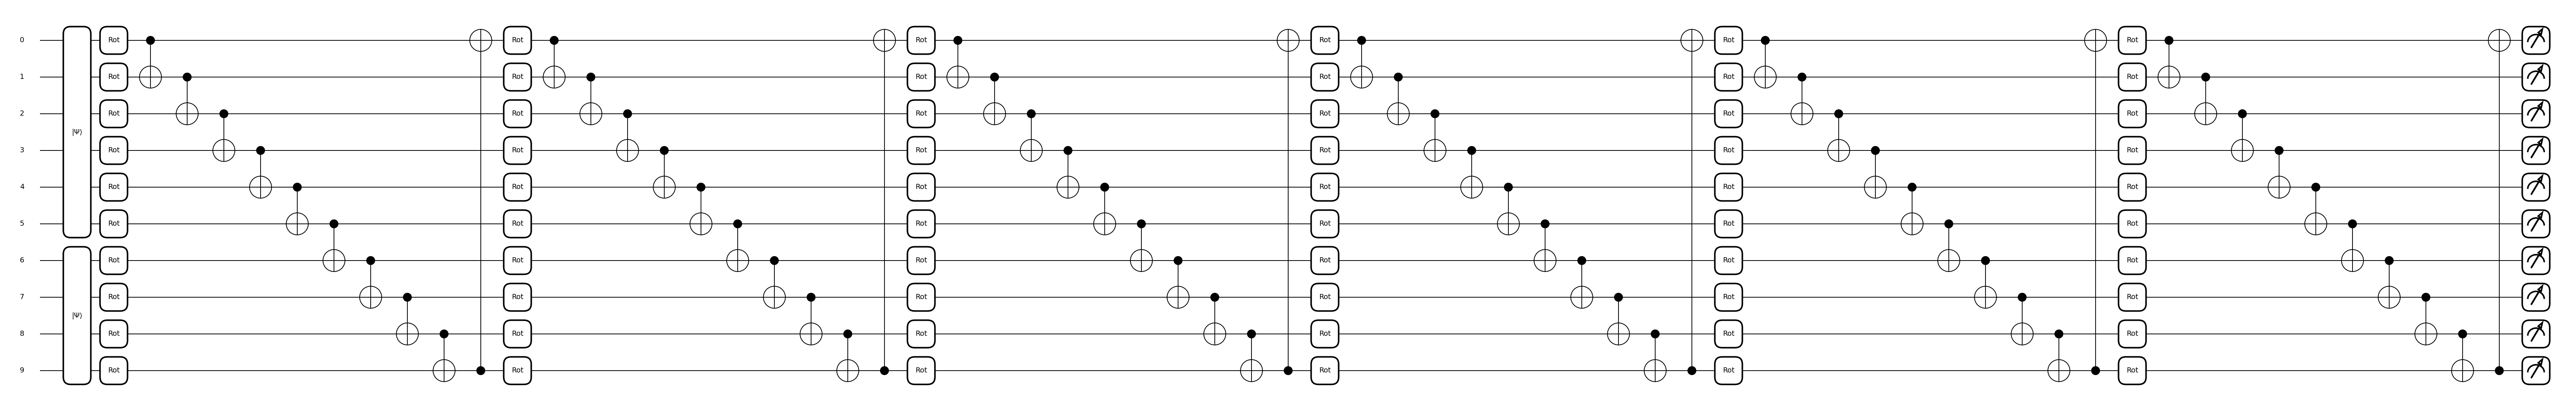

In [ ]:
from matplotlib import pyplot as plt
from torch.autograd import Variable

all_weights = Variable(0.1 * torch.randn(6, 10, 3).to(device), requires_grad=True)
all_bias = Variable(0.1 * torch.ones(1).to(device), requires_grad=True)
params = (all_weights, all_bias)

fig, ax = qml.draw_mpl(circuit)(params[0], params[1])
plt.show()

MSE Loss

In [ ]:
def mse_loss(q_circuit, all_params, feature_vecs, target_images):
    loss = 0.0
    num_samples = len(target_images)
    for i in range(num_samples):
        target = target_images[i].flatten()
        process_images = variational_circuit(q_circuit, all_params, feature_vecs[i].to(device))
        loss += torch.sum((target / torch.sum(target) - process_images) ** 2)

    loss /= num_samples

    return loss

Class for plots

In [ ]:
!pip install scikit-image
!pip install -upgrade ipywidgets
clear_output()

In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output


class ProgressPlotter:
    def __init__(self) -> None:
        self._history_dict = defaultdict(list)

    def add_scalar(self, tag: str, value) -> None:
        self._history_dict[tag].append(value)

    def display_plot(self) -> None:
        clear_output()
        n_keys = len(self._history_dict)
        fig, ax = plt.subplots(n_keys, 1, figsize=(12, 3 * n_keys))
        for key_idx, key in enumerate(self._history_dict.keys()):
            history_len = len(self._history_dict[key])
            if n_keys == 1:
                ax.plot(self._history_dict[key], color="c", marker="X")
                ax.set_ylabel(key)
                ax.set_xlabel("step")
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))
            elif n_keys > 1:
                ax[key_idx].plot(self._history_dict[key], color="c", marker="X")
                ax[key_idx].set_ylabel(key)
                ax[key_idx].set_xlabel("step")
                ax[key_idx].set_xticks(np.arange(history_len))
                ax[key_idx].set_xticklabels(np.arange(history_len))
        fig.tight_layout()
        plt.show()

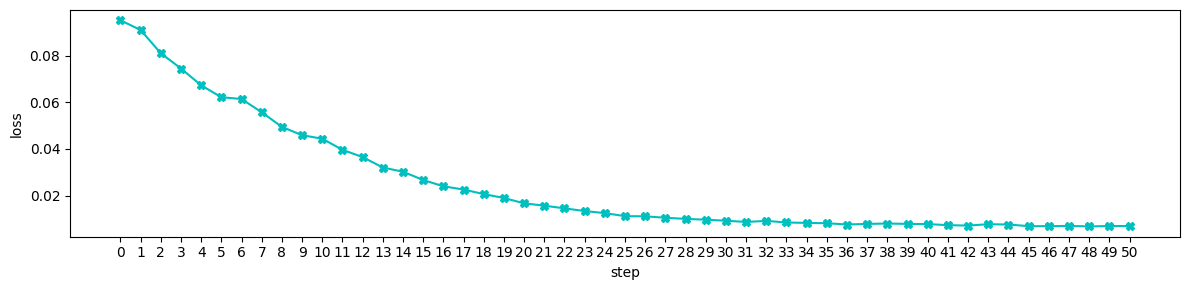

KeyboardInterrupt: ignored

In [ ]:
%%time
from tqdm.notebook import tqdm
from torch.autograd import Variable
import torch.optim as optim

lr_adam = 0.01
num_layers = 6
num_epoch = 1

pp = ProgressPlotter()

# Initialize the parameters
angles = Variable(0.1 * torch.randn(num_layers, num_qubits, 3).to(device), requires_grad=True)
#all_bias = Variable(torch.ones(32 * 32).to(device), requires_grad=True)

params = (angles,)
optimizer = optim.Adam(params, lr=lr_adam)

print("Num params: ", 3 * num_layers * num_qubits)

q_circuit = qml.QNode(circuit, dev)
batches_num = len(train_loader)

parameters = []

# train the variational classifier
for e in range(num_epoch):
    loss = 0
    k = 0
    acc = 0
    for batch in tqdm(train_loader):
        process_imgs, target_imgs = batch
        process_imgs, target_imgs = process_imgs.to(device), target_imgs.to(device)

        parameters.append(params)

        optimizer.zero_grad()

        curr_cost = mse_loss(q_circuit, params, process_imgs[:,i_arr], target_imgs)

        curr_cost.backward()
        optimizer.step()

        l = curr_cost.detach().cpu().numpy()
        #loss += l

        print(f"Epoch={e}: batch={i+1}/{batches_num}, loss={l}")

        # if i % 100 == 0:
        #     print(f"Epoch {e}: batch{i}, loss={l}")

        pp.add_scalar(tag="loss", value=l)
        pp.display_plot()

In [ ]:
measurements, target_imgs = next(iter(test_loader))
measurements, target_imgs = measurements.to(device), target_imgs.to(device)

num_samples = len(target_imgs)

process_images = []
for i in range(num_samples):
    process_images.append(variational_circuit(q_circuit, params, measurements[i][i_arr].to(device)))

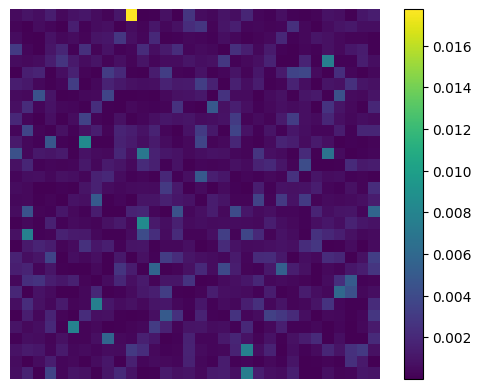

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(process_images[1].detach().cpu().reshape(32,32).numpy())
ax.set_axis_off()
fig.colorbar(im)